In [4]:
import numpy as np
import pandas as pd
import csv
import ast
import collections
import matplotlib.pyplot as plt
import random

def remove_empty_spaces(dic):
    """ Function removing an empty space at the first position of a string. 
    """
    for i in dic:
        if dic[i][:1] == " ":
            dic[i] = dic[i].strip()
    return dic

558792


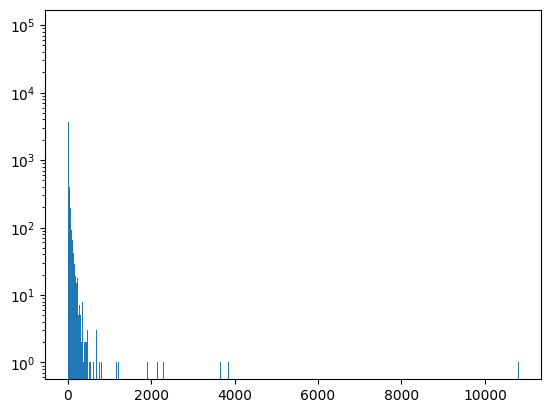

In [5]:
#Take a look at the data and basic cleaning

CORD19_CSV = pd.read_csv('../data/cord-19/CORD19_software_mentions.csv' , converters={'software': lambda x: x[1:-1].split(',')})
software = CORD19_CSV.software
software = software.explode(ignore_index = True)
software = software.str.replace('\'', '')
software.value_counts(dropna=False)
software_dict = software.to_dict()
software_dict = remove_empty_spaces(software_dict)
software_series = pd.Series(software_dict)

#This is what our data looks like on a log scale
#Approx 100k software
#Approx 600k mentions
#Note around half the data has 1 citation, around 8% >10 citations, less than 1.5% have >50
plt.hist(software_series.value_counts(),bins=1000)
plt.yscale('log', nonpositive='clip')
print(len(software_dict))


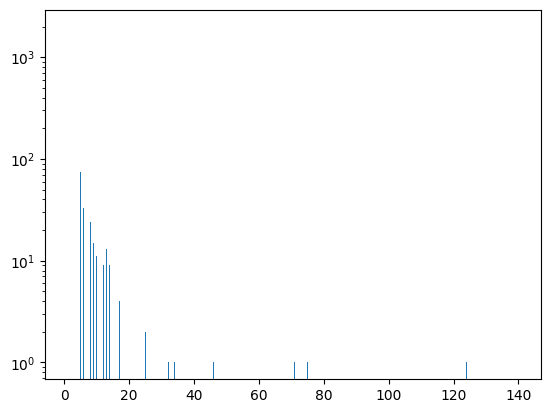

In [6]:
#Take random sample of data, save as CSV and perform same data cleaning as above

SAMPLE_COUNT = 1000

i = 0
with open('../data/cord-19/CORD19_software_mentions.csv', 'r') as csv_file:
    csv_reader = csv.reader(csv_file)
    row_count = sum(1 for row in csv_reader)
    rand_ints = random.sample(range(1, row_count), SAMPLE_COUNT)
    with open('output_random1000.csv', 'w') as output:
        output_writer = csv.writer(output, delimiter=',')
        csv_file.seek(0)
        for row in csv_reader:
            if i == 0 or i in rand_ints:
                output_writer.writerow(row)
            i += 1
            
CORD19_CSV = pd.read_csv('output_random1000.csv' , converters={'software': lambda x: x[1:-1].split(',')})
software = CORD19_CSV.software
software = software.explode(ignore_index = True)
software = software.str.replace('\'', '')
software.value_counts(dropna=False)
software_dict = software.to_dict()
software_dict = remove_empty_spaces(software_dict)
software_series_sample = pd.Series(software_dict)
plt.hist(software_series_sample.value_counts(),bins=1000)
plt.yscale('log', nonpositive='clip')

In [7]:
#Population is non-normal so to test variances use Levene's test 
#https://www.itl.nist.gov/div898/handbook/eda/section3/eda35a.htm

from scipy.stats import levene
stat,p=levene(software_series.value_counts(), software_series_sample.value_counts())
print(p)
#Actual values of variances
[np.var(x, ddof=1) for x in [software_series.value_counts(), software_series_sample.value_counts()]]

#Gives small p-values, populations don't have equal variances (unsurprisingly...)

0.003411645564316879


[3295.6001876475543, 26.035300595996723]

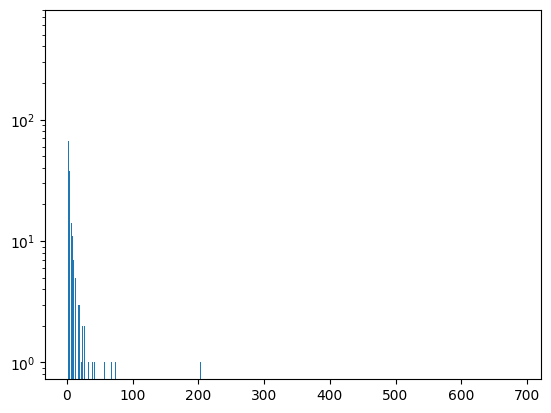

In [10]:
#Can create stratified sample, here the y data are bins to split the #citations. Visually it's not so different from the fully random sample. 
y=(np.linspace(0,0.999999999999,len(software_series.value_counts()))*1000).astype(int)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(software_series.value_counts(), y,stratify=y, test_size=1000)
plt.hist(X_test, bins=1000)
plt.yscale('log', nonpositive='clip')

In [11]:
#Does a sample look like the original (with actual tests as well as visually) if we exclude the top 100 cited?
# -> Sometimes

df_val_counts = pd.DataFrame(software.value_counts())
df_top100=df_val_counts.nlargest(100,'software')
df_without_top100=df_val_counts.nsmallest(len(df_val_counts)-100,'software')
sample_1000=df_without_top100.sample(1000)


from scipy.stats import levene
stat,p=levene(df_without_top100.software, sample_1000.software)
print(p)
#Actual values of variances
print([np.var(x, ddof=1) for x in [df_without_top100.software, sample_1000.software]])



#Save these as our sample:

sample_1000.to_csv('1000sample_without_top_100.csv',index=False)
df_top100.to_csv('top_100.csv',index=False)


0.7077717791569575
[2.015261940359568, 1.7507547547547546]
